In [1]:
#Extracting the dataset zipfile

from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "/content/drive/MyDrive/trafficnet_dataset_v1.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

File Name                                             Modified             Size
trafficnet_dataset_v1/                         2019-07-04 17:14:14            0
trafficnet_dataset_v1/test/                    2019-07-04 19:22:22            0
trafficnet_dataset_v1/test/accident/           2019-07-04 17:14:22            0
trafficnet_dataset_v1/test/accident/images (2).jpg 2018-09-24 13:28:20        15576
trafficnet_dataset_v1/test/accident/images.jpg 2018-09-24 13:30:08        14009
trafficnet_dataset_v1/test/accident/images_002 (2).jpg 2018-09-24 13:19:20        11266
trafficnet_dataset_v1/test/accident/images_002.jpg 2018-09-24 13:30:08         9695
trafficnet_dataset_v1/test/accident/images_003.jpg 2018-09-24 13:30:08        12410
trafficnet_dataset_v1/test/accident/images_004 (2).jpg 2018-09-24 13:19:20        10419
trafficnet_dataset_v1/test/accident/images_004.jpg 2018-09-24 13:30:08        11974
trafficnet_dataset_v1/test/accident/images_005 (2).jpg 2018-09-24 13:19:20         9512


In [2]:
#Import all necessary libraries

from tensorflow import keras
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Dropout,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import EarlyStopping,ReduceLROnPlateau 

In [3]:
2#Augment the images
datagen = ImageDataGenerator(
  featurewise_center=False,  # set input mean to 0 over the dataset
  samplewise_center=False,  # set each sample mean to 0
  featurewise_std_normalization=False,  # divide inputs by std of the dataset
  samplewise_std_normalization=False,  # divide each input by its std
  zca_whitening=True,  # apply ZCA whitening
  rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
  width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
  height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
  horizontal_flip=True,  # randomly flip images
  vertical_flip=False)  # randomly flip images

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [4]:
#Train dataset
trainDatagen = datagen.flow_from_directory(directory='/content/trafficnet_dataset_v1/train/',
                                           target_size=(224, 224),
                                           class_mode = 'sparse',
                                           batch_size = 64)

Found 3600 images belonging to 4 classes.


In [5]:
#Validation dataset
valDatagen = datagen.flow_from_directory(directory='/content/trafficnet_dataset_v1/test/',
                                           target_size=(224, 224),
                                           class_mode = 'sparse',
                                           batch_size = 64)

Found 800 images belonging to 4 classes.


In [6]:
#Assign numbers to each category
trainDatagen.class_indices

{'accident': 0, 'dense_traffic': 1, 'fire': 2, 'sparse_traffic': 3}

In [7]:
res_model=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3)) #Load in ResNet50

In [8]:
#model1
c1=Conv2D(16,(3,3),activation='relu')(res_model.output)
f1=Flatten()(c1)
fc=Dense(4,activation='softmax')(f1)
model=Model(res_model.inputs,fc)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
#Model2
avg=GlobalAveragePooling2D()(res_model.output)
fc1=Dense(512,activation='relu')(avg)
fc2=Dense(4,activation='softmax')(fc1)

model=Model(res_model.inputs, fc2)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [10]:
for ix in range(170):
    model.layers[ix].trainable=False #Make all the 170 layers in this model, untrainable

In [11]:
model.summary() #Get a summary of the entire model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [12]:
adam=Adam(lr=0.00001) #Our optimizer will be Adam and our learning rate is 0.0001
model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy']) #Compile the model

In [13]:
earlystop=EarlyStopping(patience=10) #Monitor the performance. If it dips, then stop training
learning_rate_reduce=ReduceLROnPlateau(monitor='val_acc',min_lr=0.00001) #Change learning rate if not performing good enough
callbacks=[earlystop,learning_rate_reduce]

In [14]:
#Start training the model with 60 epochs and train it 2 times

history=model.fit_generator(generator=trainDatagen,
                            steps_per_epoch=len(trainDatagen),
                            epochs=60,
                            validation_data=valDatagen,
                            validation_steps=len(valDatagen),
                            shuffle=True,
                            callbacks=callbacks
                          )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/60
57/57 [==============================] - 56s 924ms/step - loss: 1.5742 - accuracy: 0.3241 - val_loss: 1.0548 - val_accuracy: 0.5725
Epoch 2/60
57/57 [==============================] - 50s 896ms/step - loss: 0.9192 - accuracy: 0.6642 - val_loss: 0.7755 - val_accuracy: 0.7175
Epoch 3/60
57/57 [==============================] - 51s 889ms/step - loss: 0.7129 - accuracy: 0.7528 - val_loss: 0.6960 - val_accuracy: 0.7513
Epoch 4/60
57/57 [==============================] - 50s 885ms/step - loss: 0.6053 - accuracy: 0.7797 - val_loss: 0.6350 - val_accuracy: 0.7625
Epoch 5/60
57/57 [==============================] - 51s 890ms/step - loss: 0.5529 - accuracy: 0.8111 - val_loss: 0.5851 - val_accuracy: 0.7875
Epoch 6/60
57/57 [==============================] - 51s 887ms/step - loss: 0.5058 - accuracy: 0.8208 - val_loss: 0.5482 - val_accuracy: 0.7962
Epoch 7/60
57/57 [==============================] - 51s 889ms/step - loss: 0.4757 - accuracy: 0.8274 - val_loss: 0.5315 - val_accuracy: 0.8112

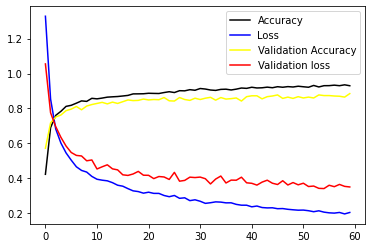

In [15]:
import matplotlib.pyplot as plt

model.save('/content/drive/MyDrive/car-accident/model.h5')

#plot this model
plt.plot(history.history['accuracy'],color='black', label='Accuracy')
plt.plot(history.history['loss'],color='blue', label='Loss')
plt.plot(history.history['val_accuracy'],color='yellow', label='Validation Accuracy')
plt.plot(history.history['val_loss'],color='red', label='Validation loss')
plt.legend()
plt.show()

In [19]:
classes = ['accident', 'dense_traffic', 'fire', 'sparse_traffic'] #Make a list of the classes

In [20]:
import keras
from keras.preprocessing.image import load_img, img_to_array  
from keras.models import load_model
import PIL
import numpy as np

def prediction(path, model, classes): #Make a function to predict an image to test this model

    img = load_img(path) #Load image
    img = img.resize((224, 224)) #Resize image
    img = img_to_array(img) #Convert into an array

    img = img.reshape( -1,224, 224,3) #Reshape it

    pred = model.predict(img) #Predict the image

    return classes[int(np.argmax(pred, axis=1))] #Return the classified labels

In [21]:
#Driver code

print(prediction('/content/trafficnet_dataset_v1/test/fire/images.jpg', model, classes))

fire
